In [ ]:
import re
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import nltk.corpus
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

from math import ceil

from sklearn import metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# 1. Preprocessing




##Loading data

In [ ]:
df = pd.read_csv("labeled_data.csv")
hatred_dict = pd.read_csv("refined_ngram_dict.csv")

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
df.isna().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [ ]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


##Correcting words

In [ ]:
from collections import Counter

def get_words(text):
  return re.findall(r'\w+', text.lower())

class WordCorrector:


  WORDS = Counter(get_words(open('big.txt').read()))

  def __init__(self):
    pass

  ## TODO
  def correct_text(self, text):
    words = get_words(text)

  #WORDS = Counter(words(open('big.txt').read())
  def P(self, word, N=sum(WORDS.values())): 
      "Probability of `word`."
      return WORDS[word] / N

  def correction(self, word): 
      "Most probable spelling correction for word."
      return max(candidates(word), key=P)

  def candidates(self, word): 
      "Generate possible spelling corrections for word."
      return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

  def known(self, words): 
      "The subset of `words` that appear in the dictionary of WORDS."
      return set(w for w in words if w in WORDS)

  def edits1(self, word):
      "All edits that are one edit away from `word`."
      letters    = 'abcdefghijklmnopqrstuvwxyz'
      splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
      deletes    = [L + R[1:]               for L, R in splits if R]
      transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
      replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
      inserts    = [L + c + R               for L, R in splits for c in letters]
      return set(deletes + transposes + replaces + inserts)
  
  def edits2(self, word): 
      "All edits that are two edits away from `word`."
      return (e2 for e1 in edits1(word) for e2 in edits1(e1))

## Cleaning tweets

In [ ]:
special_characters_regex = '[!"_$%&/()=_ˆ*¡@]'
retweet_regex = '(.*rt @\w+)+:'
space_regex = '\s+'
url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
             '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'
data_set = pd.DataFrame()
data_set['clean'] = df['tweet']
data_set['clean'] = data_set.apply(lambda row:
                        re.sub(special_characters_regex, '', 
                        re.sub('\s*RT MENTIONHERE', 'MENTIONHERE',
                        re.sub(url_regex, 'LINKHERE',
                        re.sub(mention_regex, 'MENTIONHERE',
                        re.sub(retweet_regex, '',
                        re.sub(space_regex, ' ',
                              row['clean'])))), flags=re.ASCII)), axis=1)

data_set['clean'] = data_set.apply(lambda row: row['clean'].lower(), axis=1)

#clean[:10]

In [ ]:
n = 1000
data_set = data_set[0:n]
df = df[0:n]

In [ ]:
y = df[['class']]
X = pd.DataFrame()#df[['hate_speech', 'offensive_language', 'neither']]

##Tokenization

In [ ]:
sentences = data_set.apply(lambda row: sent_tokenize(row['clean']),axis=1)
words = data_set.apply(lambda row: word_tokenize(row['clean']), axis=1)

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += [',', '.', ';']
data_set['clean'] = words.apply(lambda row: [w for w in row if w not in stopwords]) 
data_set['clean']

0      [mentionhere, :, woman, n't, complain, cleanin...
1      [mentionhere, :, boy, dats, cold, ..., tyga, d...
2      [mentionhere, dawgmentionhere, :, ever, fuck, ...
3      [mentionhere, :, mentionhere, look, like, tranny]
4      [mentionhere, :, shit, hear, might, true, migh...
                             ...                        
995    [#, 128514, #, 128514, #, 128514, #, 128514, m...
996    [#, 128514, #, 128514, #, 128514, #, 128514, b...
997    [#, 128514, #, 128514, #, 128514, #, 128514, f...
998    [#, 128514, #, 128514, #, 128514, #, 128514, #...
999    [#, 128514, #, 128514, #, 128514, #, 128514, #...
Name: clean, Length: 1000, dtype: object

In [ ]:
#posttag = words.apply(lambda row: nltk.pos_tag(row))
#posttag[0]

# 2. Vectorization

In [ ]:
joined = data_set.apply(lambda row: ' '.join(row['clean']), axis=1)
#joined

###TFiDF

In [ ]:
vectorizer = TfidfVectorizer(min_df=1)
X_tf = vectorizer.fit_transform(joined)
X_tf.column = vectorizer.get_feature_names()
X_tf.toarray()[0]
#X.column
X_tf.shape

(1000, 3329)

### TFiDF + N-grams

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=1)
X_ngram = vectorizer.fit_transform(joined)
X_ngram.column = vectorizer.get_feature_names()
X_ngram.shape

(1000, 7341)

### TFiDF + N-grams + POS tagging

In [ ]:
tagged = data_set['clean'].apply(nltk.pos_tag)
tagged

0      [(mentionhere, RB), (:, :), (woman, NN), (n't,...
1      [(mentionhere, RB), (:, :), (boy, NN), (dats, ...
2      [(mentionhere, RB), (dawgmentionhere, RB), (:,...
3      [(mentionhere, RB), (:, :), (mentionhere, JJ),...
4      [(mentionhere, RB), (:, :), (shit, JJ), (hear,...
                             ...                        
995    [(#, #), (128514, CD), (#, #), (128514, CD), (...
996    [(#, #), (128514, CD), (#, #), (128514, CD), (...
997    [(#, #), (128514, CD), (#, #), (128514, CD), (...
998    [(#, #), (128514, CD), (#, #), (128514, CD), (...
999    [(#, #), (128514, CD), (#, #), (128514, CD), (...
Name: clean, Length: 1000, dtype: object

### Other Features

####RTs

In [ ]:
X['RT'] = df.apply(lambda row: row["tweet"].count("RT") , axis=1)

####Number of words

In [ ]:
X['num_words'] = words.apply(len)
X.isna().sum()

RT           0
num_words    0
dtype: int64

####Number of sentences

In [ ]:
X['num_sents'] = sentences.apply(len)
X.isna().sum()

RT           0
num_words    0
num_sents    0
dtype: int64

####Sentiment analisis

In [ ]:
sentiment_analyzer  = SentimentIntensityAnalyzer() 
sentiment = joined.apply(lambda row: sentiment_analyzer.polarity_scores(row))
sentiment = pd.DataFrame.from_records(sentiment)
if not any(c == 'neg' for c in X.columns):
  X = pd.concat([X, sentiment], axis=1)
else:
  X.update(sentiment)
X.isna().sum()

RT           0
num_words    0
num_sents    0
neg          0
neu          0
pos          0
compound     0
dtype: int64

####Hatred n-gram dictionary

In [ ]:

#def get_weight(row):
#  return max(hd['prophate'] if hd['ngram'] in row else 0 for i, hd in hatred_dict.iterrows())
'''weight = 0
  for i in range(len(props)):
    if ngrams[i] in row and props[i] > weight:
      weight = props[i]
  return weight '''

#data_set['hatedict'] = joined.apply(get_weight) 
X['hatedict'] = joined.apply(
    lambda row: max(hd['prophate'] if hd['ngram'] in row else 0 
                    for _, hd in hatred_dict.iterrows())) 


In [ ]:
X.describe()
max(X['hatedict'])

0.912

# 3. Feature selection

In [ ]:
'''from functools import reduce
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='constant', fill_value=0)
imp.fit(X_tf)
X_tf = imp.transform(X_tf)'''
X_tf_df = pd.DataFrame.sparse.from_spmatrix(X_tf)

In [ ]:
X, X_tf_df

(     RT  num_words  num_sents    neg    neu    pos  compound  hatedict
 0     1         28          2  0.000  0.839  0.161    0.2755       0.0
 1     1         17          1  0.226  0.774  0.000   -0.5423       0.0
 2     2         19          2  0.803  0.197  0.000   -0.9460       0.0
 3     1          8          1  0.000  0.615  0.385    0.3612       0.0
 4     1         27          1  0.407  0.440  0.154   -0.6808       0.0
 ..   ..        ...        ...    ...    ...    ...       ...       ...
 995   1         34          1  0.245  0.755  0.000   -0.5994       0.0
 996   0         47          1  0.183  0.817  0.000   -0.5859       0.0
 997   0         25          2  0.304  0.696  0.000   -0.5423       0.0
 998   0         78          1  0.123  0.877  0.000   -0.5859       0.0
 999   1         26          1  0.516  0.484  0.000   -0.8625       0.0
 
 [1000 rows x 8 columns],
      0     1     2     3     4     5     ...  3323  3324  3325  3326  3327  3328
 0     0.0   0.0   0.0   0

In [ ]:
from pandas import concat
X = pd.concat([X, X_tf_df], axis=1)

In [ ]:
X.columns
X.isna().sum().sum()

0

In [ ]:
size = len(X.columns)
to_cut = ceil(0.7*len(X.columns))
to_save = size - to_cut
print('100% of features: {}\n 70% of features: {}'.format(size, to_cut))

100% of features: 3337
70%  of features: 2336


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

selector = SelectKBest(f_regression, k=to_save)
selector.fit(X, y)
X_new = selector.transform(X)
columns = list(X.columns[selector.get_support(indices=True)])


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
columns[:9]

['num_sents', 'neg', 'neu', 'pos', 'compound', 'hatedict', 0, 2, 3]

# 4. Classification algorithm

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, random_state=2, test_size=0.3)

##Random forest

###Model training

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(Xtrain, ytrain)
ypred_forest = model.predict(Xtest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


###Test results

              precision    recall  f1-score   support

           0       0.22      1.00      0.36         4
           1       1.00      0.82      0.90       282
           2       0.25      0.93      0.40        14

    accuracy                           0.83       300
   macro avg       0.49      0.92      0.55       300
weighted avg       0.95      0.83      0.87       300



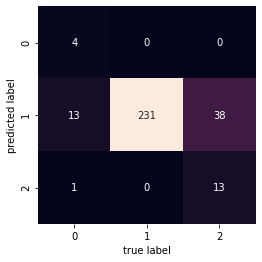

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

mat_forest = confusion_matrix(ytest, ypred_forest)
sns.heatmap(mat_forest.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(metrics.classification_report(ypred_forest, ytest))

In [ ]:
forest_score = metrics.accuracy_score(ytest, ypred_forest)
print(f'{forest_score}')

0.8266666666666667


##Support vector classifier

In [ ]:
from sklearn.svm import SVC
model_svc = SVC(kernel='linear', C=1E10)
model_svc.fit(Xtrain, ytrain)
ypred_svm = model.predict(Xtest)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Test results

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        18
           1       0.82      1.00      0.90       231
           2       0.93      0.25      0.40        51

    accuracy                           0.83       300
   macro avg       0.92      0.49      0.55       300
weighted avg       0.85      0.83      0.78       300



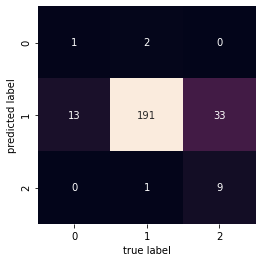

In [ ]:
mat_svm = confusion_matrix(ytest, ypred)
sns.heatmap(mat_svc.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(metrics.classification_report(ytest, ypred_svm))

In [ ]:
svm_score = metrics.accuracy_score(ytest, ypred)
print(f'{svm_score}')

0.7266666666666667
